In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column
from astropy.table import vstack, hstack

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
from matplotlib import rc

mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


## This notebook reads in Keith's abundances and Guy's asteroseismology to produce the tables for the paper.

In [2]:
fname_diff = "../data/abundtable_ref.fits"
fname_nodiff = "../data/abundtable.fits"

fname_nodiff_extra = '../data/abundtable_badstars.fits'
fname_diff_extra = '../data/abundtable_ref_badstars.fits'

In [3]:
diff = Table.read(fname_diff)
diff.rename_column('Star','Object')
diff.sort('Object')

diff_extra = Table.read(fname_diff_extra)
diff_extra.rename_column('Star','Object')
diff_extra.sort('Object')

diff = vstack(diff,diff_extra)
diff.write('abundances_diff.csv',format='ascii')

nodiff = Table.read(fname_nodiff)
nodiff.rename_column('Star','Object')
nodiff.sort('Object')

nodiff_extra = Table.read(fname_nodiff_extra)
nodiff_extra.rename_column('Star','Object')
nodiff_extra.sort('Object')

nodiff = vstack(nodiff,nodiff_extra)
nodiff.write('abundances_nodiff.csv',format='ascii')


How do abundances compare between the differential and non-differential methods? Not too badly. Many more elements lack differential abundances than absolute abundances so it looks like in the paper we shouldn't use the differential. Good to include in online data though.

In [4]:
# for j, key in enumerate(diff.keys()[1:]):
#     if key[0]=='e':
#         continue
#     plt.figure(j)
#     plt.plot(diff[key],nodiff[key],'.')
#     plt.title(key)

In [5]:
# nodiff.keys()

In [6]:
# diff

### Create a string-formatted table merging abundances with their uncertainties appropriately.

In [7]:
alpha = ['Mg','Ti','Si','Ca','Al','V','Ni']
neutron = ['Sr','Y','Zr','Ba','La','Eu']

In [8]:
for ell in neutron:
    print(ell)

Sr
Y
Zr
Ba
La
Eu


In [9]:
([str(obj).replace('_',' ').replace('BD ','BD+') for obj in diff['Object'].astype('str')])

['BD+36 3564',
 'BD+39 3577',
 'BD+42 3150',
 'BD+48 2904',
 'BD+48 2955',
 'HD 174829',
 'HD 175740',
 'HD 175884',
 'HD 178797',
 'HD 178910',
 'HD 179396',
 'HD 180312',
 'HD 180475',
 'HD 180658',
 'HD 180682',
 'HD 181069',
 'HD 181097',
 'HD 181597',
 'HD 181778',
 'HD 181880',
 'HD 182354',
 'HD 182531',
 'HD 182692',
 'HD 182694',
 'HD 183124',
 'HD 185286',
 'HD 188537',
 'HD 189750',
 'HD 226754']

In [10]:
newtab = Table([Column([str(obj).replace('_',' ').replace('BD ','BD+') for obj in diff['Object']],name='Object')])

# first do the differential elements

for el in alpha:
    col = diff[el]
    ecol = diff['%serr' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (float(col[j]),float(ecol[j])) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))
    newtab.add_column(test)
    
#     print el

# Then do the neutron capture elements
newtab2 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for ell in neutron:
    col = nodiff[ell]
    ecol = nodiff['%serr' % ell]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (float(col[j]),float(ecol[j])) for j, x in enumerate(col)],name='[%s/Fe]' % ell)
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab2.add_column(test)
    

In [11]:
def oxford_join(string_list):
    '''From https://stackoverflow.com/questions/19838976/grammatical-list-join-in-python'''
    if len(string_list) < 1:
        text = ''
    elif len(string_list) == 1:
        text = string_list[0]
    elif len(string_list) == 2:
        text = ' and '.join(string_list)
    else:
        text = ', '.join(string_list)
        text = '{parts[0]}, and {parts[2]}'.format(parts=text.rpartition(', '))  # oxford comma
    return text

## Now produce three LaTeX tables to go into the paper directory.

In [12]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'

caption1 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS,  differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in filter(lambda x: x !='O_Fe',alpha)])
caption2 = r'Chemical abundances relative to iron of neutron capture elements for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in neutron])
# caption3 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[15:]])

caption1 = caption1+r'The catalogue of abundances for neutron capture elements continues in Table~\ref{elems2}.'
# caption2 = caption2+r'The catalogue of abundances for more elements continues in Table~\ref{elems3}.'


newtab.write('../paper/abundances_1.tex',format='latex',latexdict=latexdict,caption=caption1+'\label{elems1}')
newtab.write('../paper/abundances_1_apj.tex',format='aastex',caption=caption1+'\label{elems1}')

newtab2.write('../paper/abundances_2.tex',format='latex',latexdict=latexdict,caption=caption2+'\label{elems2}')
newtab2.write('../paper/abundances_2_apj.tex',format='aastex',caption=caption2+'\label{elems2}')

# newtab3.write('../paper/abundances_3.tex',format='latex',latexdict=latexdict,caption=caption3+'\label{elems3}')

### Now let's also do the stellar properties

In [13]:
fname_merged ="../data/abundances/final_pope_merged.fits"
fname_merged = '../data/spc_final.txt'
fname_mass = '../data/smeartest201018_SeismoFullove02_full_notefftol.ascii'
fname_mass_extra = '../data/smeartest_full.ascii'

merged = Table.read(fname_merged,format='ascii')
masses = Table.read(fname_mass,format='ascii')
masses_extra = Table.read(fname_mass_extra,format='ascii') # fix the bad stars 

for obj in masses_extra:
    for key in masses.keys()[1:]:
        m = masses['Object']==obj['Object']
        masses[key][m] = obj[key]

masses['age'] /= 1000. # Gyr not Myr
masses['age_errp'] /= 1000.
masses['age_errm'] /= 1000.

# fname_spc = "../data/spc_final.txt"
# spc = Table.read(fname_spc,format='ascii')
astero_logg = Table.read('../data/pope_asteroseismology.csv')
# merged = Table.read(fname_merged)
merged.rename_column('RVerr','RV_err')
merged.keys()
merged.sort('Object')
joint = join(merged,astero_logg,keys='Object')
joint = join(joint,masses,keys='Object')
joint.write('all_props.csv',format='ascii')

In [14]:
masses.keys()

['Object',
 'massfin',
 'massfin_errp',
 'massfin_errm',
 'radPhot',
 'radPhot_errp',
 'radPhot_errm',
 'logg',
 'logg_errp',
 'logg_errm',
 'age',
 'age_errp',
 'age_errm']

In [15]:
counter = []
counter2 = []
for obj in merged['Object']:
    if obj not in astero_logg['Object']:
#         print obj
        counter.append(obj)
for obj in astero_logg['Object']:
    if obj not in merged['Object']:
#         print obj
        counter2.append(obj)

# print len(counter)
# print len(counter2)
# print counter

In [16]:
for j, obj in enumerate(astero_logg['Object']):
    ind = merged['Object']==obj
    merged[ind]['log_g'] = astero_logg['log_g'][j]
    merged[ind]['log_g_err'] = astero_logg['log_g_err'][j]

In [17]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in joint['Object']],name='Object')])

newkeys = ['RV', 'Teff', 'log_g', 'monh','vsini','SNRe']
names = [r'RV',r'\teff', r'\logg',r'[M/H]',r'$V\sin{i}$',r'SNR']
units = [r'(km/s)', r'(K)', '','','(km/s)','']

for k, key in enumerate(newkeys):
    col = joint[key]
    if key+'_err' in joint.keys():
        ecol = joint['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)
    
amaliekeys = ['massfin','radPhot','age']
amalienames = ['Mass', 'Radius','Age']
amalieunits = ['(\msun)','(\\rsun)','(Gyr)']

for k, key in enumerate(amaliekeys):
    col = joint[key]
    ecolp = joint['%s_errp' % key]
    ecolm = joint['%s_errm' % key]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f^{+%.2f}_{-%.2f}$' % (col[j],ecolp[j],ecolm[j]) for j, x in enumerate(col)],name=amalienames[k])
    
    newtab.add_column(test)


In [18]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names+amalienames,units+amalieunits))

caption = r'Fundamental stellar parameters for the red giant sample as determined jointly by asteroseismology (asteroseismic \logg; Section~\ref{asteroseismology}) and spectroscopy (%s; Section~\ref{spectroscopy}.)' % oxford_join(names+amalienames)  
caption = caption+r'\label{stellar_props}'
newtab.write('../paper/stellar_props.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}')

In [19]:
caption = r'Fundamental stellar parameters for the red giant sample as determined jointly by asteroseismology (asteroseismic \logg; Section~\ref{asteroseismology}) and spectroscopy (%s; Section~\ref{spectroscopy}.)' % oxford_join(names+amalienames)  
caption = caption+r'\label{stellar_props}'

newtab.write('../paper/stellar_props_apj.tex',format='aastex',caption=caption,overwrite=True)
with open('../paper/stellar_props_apj.tex', 'r') as original: oldtext = original.read()
with open('../paper/stellar_props_apj.tex', 'w') as modified: modified.write("\\begin{longrotatetable}\n" + oldtext+'\\end{longrotatetable}\n')



### Now let's look at the proper spectroscopy with Dnu measurements

In [20]:
fname_seismic = "../data/smear_Dnu.csv"
seismic = Table.read(fname_seismic)
seismic.remove_row(np.where(seismic['Star_ID']=='HD_189636')[0][0])
seismic.sort('Star_ID')

In [21]:
seismic

Star_ID,Dnu,Dnu_err,Numax,Numax_err,eps,eps_err
str10,float64,float64,float64,float64,float64,float64
BD+36_3564,0.9490949804411055,0.030097283743239316,5.079062736733746,0.09882652247868091,0.8305746287171062,0.20003026391376488
BD+39_3577,1.6836250688792482,0.01363988821142889,13.266855807051439,0.31633186319569034,0.7409609522947077,0.06299253167276896
BD+42_3150,4.221788591943251,0.028504804862306103,38.315943379269186,0.9588694546996247,0.7013731801198373,0.07075600621249865
BD+43_3171,0.41728859981040545,0.05318387492844148,1.984298734336489,0.05145104900196677,0.8040170562496404,0.17159665699501567
BD+43_3213,0.48750734592283734,0.006958633078022336,2.5632797174106847,0.06325084146747773,1.0124195735754942,0.07326685394355063
BD+48_2904,2.8511597676805804,0.010318892608438912,23.13453453354469,0.7225398099392429,0.8563054208127122,0.08052669688943252
BD+48_2955,0.8953098233940573,0.0068208356847463585,5.440132725276065,0.08331498484403516,0.8105480979445374,0.052471147709803705
HD_174020,0.5639183284003043,0.01603666749035637,2.47548965209216,0.09744999575175439,0.8926590744791576,0.08467569516842773
HD_174829,1.2833572675283929,0.011357043983480081,7.9497984768617815,0.1571667547811646,0.7755393571480604,0.05755641850899791


In [22]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in seismic['Star_ID']],name='Object')])

newkeys = ['Dnu', 'Numax', 'eps']
names = [r'\Dnu',r'\numax', r'$\epsilon$']
units = [r'(\muHz)', r'(\muHz)','']

for k, key in enumerate(newkeys):
    col = seismic[key]
    if key+'_err' in seismic.keys():
        ecol = seismic['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table'
latexdict['units'] = dict(zip(names,units))

caption = r'Global asteroseismic parameters %s for the red giant sample as discussed in Section~\ref{asteroseismology}.' % oxford_join(names)  
caption = caption+r'\label{astero_table}'
newtab.write('../paper/astero_table.tex',format='latex',latexdict=latexdict,caption=caption)
newtab.write('../paper/astero_table_apj.tex',format='aastex',caption=caption,overwrite=True)


### Notes on individual stars from Guy Davies

BD+39_388 - No secure detection.

BD+43_306 - Big peaks but not consistent enough with RG pattern.

HD_179959 - Pattern is too complicated - is this two stars??  Literature says no.

HD_185351 - Odd mode envelope - No explanation.

HD_187217 - No info on this star - maybe a double but very difficult to tell.

HD_188639 - Too difficult to get a robust Dnu.

HD_188875 -  Too difficult to get a robust Dnu.

HD_188629 - Too difficult to get a robust Dnu.



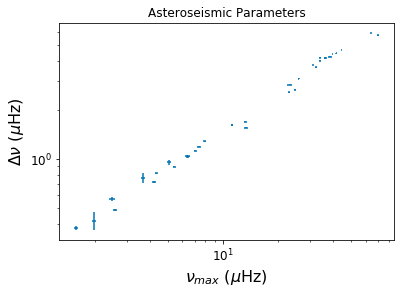

In [23]:
# the stars follow the expected numax-Dnu relation
plt.errorbar(seismic['Numax'],seismic['Dnu'],xerr=seismic['Numax_err'],yerr=seismic['Dnu_err'],linestyle='none')
plt.xlabel(r'$\nu_{max}$ ($\mu$Hz)')
plt.ylabel(r'$\Delta\nu$ ($\mu$Hz)')
plt.title('Asteroseismic Parameters')
plt.xscale('log')
plt.yscale('log')

### Which ones are missing?

In [24]:
badstars = ['BD+39_388','BD+43_306','HD_179959','HD_185351','HD_187217','HD_188639','HD_188875','HD_188629']
notes = ['No secure detection','Not consistent with RG pattern','Possible contamination',r'\citep{2017MNRAS.464.3713H}',
         'Possible contamination or binary',r'Too difficult to get a robust \Dnu',r'Too difficult to get a robust \Dnu',
         r'Too difficult to get a robust \Dnu']

notecol = [notes[j] if star in badstars else '' for j, star in enumerate(seismic['Star_ID'])]

In [25]:
np.sort(badstars)

array(['BD+39_388', 'BD+43_306', 'HD_179959', 'HD_185351', 'HD_187217',
       'HD_188629', 'HD_188639', 'HD_188875'], dtype='<U9')

In [26]:
for star in merged['Object']:
    if star not in seismic['Star_ID']:
        print(star)

HD_176209


In [27]:
for star in seismic['Star_ID']:
    if star not in merged['Object']:
        print(star)

## Read the main catalogue

In [28]:
fname_cat = '../data/catalogue.csv'
cat = Table.read(fname_cat,format='ascii')
cat.sort('kepmag')

In [29]:
# cat

In [30]:
# print 'Clump Candidates:',oxford_join([name.replace('_',' ') for name in cat[np.array(['clump' in thing for thing in list(cat['Notes'].data.data[:])])]['Name']])

### Now to get SIMBAD queries

In [31]:
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy import units as u


In [32]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('sptype')
sim = Simbad.query_objects(cat['Name'])
cat['SpType'] = sim['SP_TYPE']
# sim.write('smear_intermediate.csv',format='ascii.csv')
# sim = Table.read('smear_intermediate.csv',format='ascii.csv')
c = coord.SkyCoord(ra=sim['RA'], dec=sim['DEC'],unit=(u.hourangle, u.deg), frame='icrs')


In [33]:
sim.keys()

['MAIN_ID',
 'RA',
 'DEC',
 'RA_PREC',
 'DEC_PREC',
 'COO_ERR_MAJA',
 'COO_ERR_MINA',
 'COO_ERR_ANGLE',
 'COO_QUAL',
 'COO_WAVELENGTH',
 'COO_BIBCODE',
 'SP_TYPE',
 'SP_QUAL',
 'SP_BIBCODE']

In [34]:
new = Table([Column([cc.ra.deg for cc in c],name='RA',unit='deg',description='RA'),Column([cc.dec.deg for cc in c],name='Dec',unit='deg',description='Dec')],masked=False)
# new.write('../data/smear_simbad.csv',overwrite=True)
cat['RA'] = new['RA']
cat['Dec']= new['Dec']

We then use the gaia tap service at http://gaia.ari.uni-heidelberg.de/tap.html for crossmatch 
using the command

SELECT bj.source_id, sm.ra, sm.dec, sm.phot_g_mean_mag, bj.r_est, bj.r_lo, bj.r_hi
FROM gaiadr2_complements.geometric_distance as bj 
JOIN TAP_UPLOAD.smear AS sm ON sm.source_id = bj.source_id

In [35]:
def crossmatch(ra_in,dec_in,ra_match,dec_match):
    ra_in, dec_in = gaia['ra'],gaia['dec']
    ra_match, dec_match = new['RA'],new['Dec']
    npoints = len(ra_in)

    m = []
    for j in range(npoints):
        dists = np.sqrt((ra_in-ra_match[j])**2+(dec_in-dec_match[j])**2)
        m.append(np.argmin(dists))
    return m

In [36]:
gaia = Table.read('../data/gaia_new.csv')
# gaia[gaia['source_id']==2128480311802353536]


dists = Table.read('../data/dists_new.csv')
dists.insert_row(38,
                 vals={'source_id':2128480311802353536,'r_est':np.nan,'r_lo':np.nan,'r_hi':np.nan})
gaia = join(dists,gaia,keys='source_id')

gaia_indices = crossmatch(gaia['ra'],gaia['dec'],new['RA'],new['Dec'])
gaia = gaia[gaia_indices]

cat.add_column(gaia['source_id'])
newcat = join(cat,gaia,keys='source_id')

In [37]:
# gaia.keys()

In [38]:
# ## check we got it right! 
# plt.scatter(cat['RA'],cat['Dec'])
# plt.scatter(gaia['ra'],gaia['dec'])

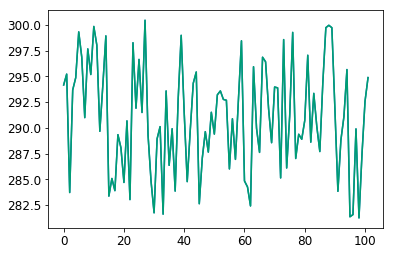

In [39]:
plt.plot(cat['RA'])
plt.plot(gaia['ra'])

In [40]:
def abs_mag(app_mag,dist):
    return app_mag - 5.*(np.log10(dist) - 1.)

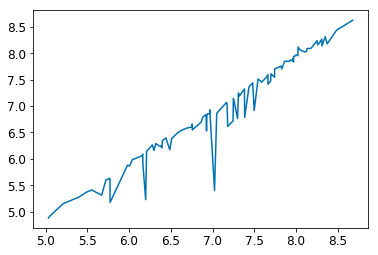

In [41]:
plt.plot(cat['kepmag'],gaia['phot_g_mean_mag'])

In [42]:
# cat[np.abs(gaia['phot_g_mean_mag']-cat['kepmag'])>0.75]#.sort(np.abs(dists['phot_g_mean_mag']-cat['kepmag']))

In [43]:
# gaia[np.abs(gaia['phot_g_mean_mag']-cat['kepmag'])>0.75]#.sort(np.abs(dists['phot_g_mean_mag']-cat['kepmag']))

In [44]:
# Table(gaia['source_id']).write('sources.csv')

In [45]:
# newcat = cat.copy()
brightkep = Table.read('../data/Bright_Kep_new.csv')
var = Table.read('../data/variability.csv')
newcat = join(cat,brightkep,keys='Name')
newcat = join(newcat,var,keys='Name')
fname_spc = '../data/spc_giants.csv'
# fname_spc = '../data/spc_final.txt'
spc_data = Table.read(fname_spc,format='ascii')

newcat['TRES?'] = ['TRES' if obj in spc_data['Object'] else '--' for obj in newcat['Name']]
# newcat.add_column(gaia['source_id'])

full_cat = join(newcat,gaia,keys='source_id',join_type=u'left')

bp, rp, gg = full_cat['phot_bp_mean_mag'], full_cat['phot_rp_mean_mag'], full_cat['phot_g_mean_mag']
abs_gg = abs_mag(gg,full_cat['r_est'])
full_cat['abs_gg'] = abs_gg
full_cat['bp_rp'] = bp-rp
abs_gg_hi = abs_mag(full_cat['phot_g_mean_mag'],full_cat['r_hi'])
abs_gg_lo = abs_mag(full_cat['phot_g_mean_mag'],full_cat['r_lo'])

full_cat.sort('Name')

full_cat.write('full_cat.csv')

# newcat = join(newcat,gaia['bp_rp','source_id','r_est','r_lo','r_hi','phot_g_mean_mag'],keys='source_id',join_type=u'left')
newcat = full_cat.copy() # just keep all the keys
newcat.sort('Name')

In [46]:
# gaia['Name'] = [newcat['Name'][newcat['source_id']==obj][0] for obj in gaia['source_id']]

# gaia['TRES'] = [newcat['TRES?'][newcat['source_id']==obj][0] for obj in gaia['source_id']]
pdg = full_cat.to_pandas()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: TableReplaceWarning: converted column 'Teff' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: TableReplaceWarning: converted column 'Edge_Dist' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: TableReplaceWarning: converted column 'flame_flags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [47]:
newcat.write('all_stars.csv')
for l, ccat in enumerate([newcat[:52],newcat[52:]]):

    newtab = Table([Column([str(obj).replace('_',' ') for obj in ccat['Name']],name='Object')])

    newkeys = ['Kepler_ID','SpType','kepmag', 'phot_g_mean_mag','bp_rp','r_est','TRES?','Class']
    names = [r'KIC',r'Spectral Type',r'$Kp$',r'$G$',r'$Bp-Rp$',r'\gaia Distance','TRES','Variability']
    units = ['',r'(SIMBAD)', r'(mag)','(mag)',r'(mag)','(pc)','','Class']
    
    translator_class = {'LPV':'LPV',
                        'RG':'RG',
                        'GD/DS Hybrid':r'$\gamma\,\text{Dor} /\delta\,\text{Sct}$',
                        'GD':r'$\gamma\,\text{Dor}$',
                        'DS':r'$\delta\,\text{Sct}$',
                        '?':'?',
                        '-':r'--',
                        'Hump & Spike':'H+S',
                        'GD/Hump & Spike':r'$\gamma\,\text{Dor}$,\,H+S',
                        'SPB/Hump & Spike':r'SPB,\,H+S',
                        'EV':'EV',
                        'EB':'EB',
                        'SPB':'SPB',
                        'Irregular':'Irregular',
                        'a2cvn':r'$\alpha^2\,\text{CVn}$',
                        'RM':r'RM',
                        'Eruptive':r'Eruptive'
                       }

    for k, key in enumerate(newkeys):
        col = ccat[key]
        if 'RE' in key:
            test = Column(['\checkmark' if 'TRES' in entry else '--' for entry in col],name=names[k])
        elif 'bs' in key:
            test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
        elif 'ype' in key:
            test = Column(['--' if np.ma.is_masked(entry) else entry for entry in col],name=names[k])
        elif 'est' in key:
            upcol = ccat['r_hi']
            downcol = ccat['r_lo']
            test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
        elif key =='Class':
            test = Column([translator_class[entry] for entry in col],name=names[k])
        elif 'mag' in key:
            test = Column(['%.3f' % d for d in col.data],name=names[k])
        elif 'bp' in key:
            test = Column(['%.3f' % d for d in col.data],name=names[k])
        else:
            test = Column(col.data,name=names[k])
#         if key == 'TRES?':
#             test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
        newtab.add_column(test)
    
    latexdict = ascii.latex.latexdicts['AA'].copy()
    latexdict['tabletype']= 'table*'
    latexdict['units'] = dict(zip(names,units))
    if l == 0:
        caption = r"The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. \
        Calibrated \gaia distances are from \citet{gaiadists}. \
        The eclipsing binary V2083~Cyg was detected by \gaia, but a parallax could not be obtained in DR2, possibly due to binary motion.\
        Variability classes are determined by inspection, having their usual abbreviations. \
        EV denotes an ellipsoidal variable, and RM rotational modulation, though these two can appear similar. $\alpha^2\,\text{CVn}$ variables are chemically-peculiar stars with rotational spot modulation,\
        and are noted separately from RM without chemical peculiarity.\
        $\gamma\,\text{Dor} /\delta\,\text{Sct}$ denotes a $\gamma\,\text{Dor} /\delta\,\text{Sct}$ hybrid, not uncertainty.\
        H+S denotes a `hump and spike' star.\
        Question marks indicate uncertainty, and dashes -- that no significant variability is observed." 
        caption = caption+r'\label{all_stars}'
        newtab.write('../paper/all_stars.tex',format='latex',latexdict=latexdict,caption=caption+'\label{all_stars}')
        print('Written %s' % '../paper/all_stars.tex')
    else:
        latexdict['preamble'] = '\contcaption{The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. Calibrated \gaia distances are from \citet{gaiadists}. \label{all_stars_cont}}'
        newtab.write('../paper/all_stars2.tex',format='latex',latexdict=latexdict)
        print('Written %s' % '../paper/all_stars2.tex')
        

newtab = Table([Column([str(obj).replace('_',' ') for obj in newcat['Name']],name='Object')])

newkeys = ['Kepler_ID','SpType','kepmag', 'phot_g_mean_mag','r_est','Observed', 'TRES?','Class']
names = [r'KIC',r'Spectral Type',r'$Kp$',r'$G$',r'\gaia Distance',r'Observed','Spectroscopy','Variability']
units = ['',r'(SIMBAD)', r'(mag)','(mag)','(pc)','','','Class']

for k, key in enumerate(newkeys):
    col = newcat[key]
    if 'bs' in key:
        test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
    elif 'ype' in key:
        test = Column(['--' if np.ma.is_masked(entry) else entry for entry in col],name=names[k])
    elif 'est' in key:
        upcol = newcat['r_hi']
        downcol = newcat['r_lo']
        test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
    elif key =='Class':
        test = Column([translator_class[entry] for entry in col],name=names[k])
    elif 'mag' in key:
        test = Column(['%.3f' % d for d in col.data],name=names[k])
    elif 'bp' in key:
        test = Column(['%.3f' % d for d in col.data],name=names[k])
    else:
        test = Column(col.data,name=names[k])
#     if key == 'TRES?':
#         test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))


Written ../paper/all_stars.tex
Written ../paper/all_stars2.tex


In [48]:
ccat = newcat.copy()
newtab = Table([Column([str(obj).replace('_',' ') for obj in ccat['Name']],name='Object')])

newkeys = ['Kepler_ID','SpType','kepmag', 'phot_g_mean_mag','bp_rp','r_est','TRES?','Class']
names = [r'KIC',r'Spectral Type',r'$Kp$',r'$G$',r'$Bp-Rp$',r'\gaia Distance','TRES','Variability']
units = ['',r'(SIMBAD)', r'(mag)','(mag)',r'(mag)','(pc)','','Class']

translator_class = {'LPV':'LPV',
                    'RG':'RG',
                    'GD/DS Hybrid':r'$\gamma\,\text{Dor} /\delta\,\text{Sct}$',
                    'GD':r'$\gamma\,\text{Dor}$',
                    'DS':r'$\delta\,\text{Sct}$',
                    '?':'?',
                    '-':r'--',
                    'Hump & Spike':'H+S',
                    'GD/Hump & Spike':r'$\gamma\,\text{Dor}$,\,H+S',
                    'SPB/Hump & Spike':r'SPB,\,H+S',
                    'EV':'EV',
                    'EB':'EB',
                    'SPB':'SPB',
                    'Irregular':'Irregular',
                    'a2cvn':r'$\alpha^2\,\text{CVn}$',
                    'RM':r'RM',
                    'Eruptive':r'Eruptive'
                   }

for k, key in enumerate(newkeys):
    col = ccat[key]
    if 'RE' in key:
        test = Column(['\checkmark' if 'TRES' in entry else '--' for entry in col],name=names[k])
    elif 'bs' in key:
        test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
    elif 'ype' in key:
        test = Column(['--' if np.ma.is_masked(entry) else entry for entry in col],name=names[k])
    elif 'est' in key:
        upcol = ccat['r_hi']
        downcol = ccat['r_lo']
        test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
    elif key =='Class':
        test = Column([translator_class[entry] for entry in col],name=names[k])
    elif 'mag' in key:
        test = Column(['%.3f' % d for d in col.data],name=names[k])
    elif 'bp' in key:
        test = Column(['%.3f' % d for d in col.data],name=names[k])
    else:
        test = Column(col.data,name=names[k])
#         if key == 'TRES?':
#             test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
    newtab.add_column(test)

caption = r"The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. \
Calibrated \gaia distances are from \citet{gaiadists}. \
The eclipsing binary V2083~Cyg was detected by \gaia, but a parallax could not be obtained in DR2, possibly due to binary motion.\
Variability classes are determined by inspection, having their usual abbreviations. \
EV denotes an ellipsoidal variable, and RM rotational modulation, though these two can appear similar. $\alpha^2\,\text{CVn}$ variables are chemically-peculiar stars with rotational spot modulation,\
and are noted separately from RM without chemical peculiarity.\
$\gamma\,\text{Dor} /\delta\,\text{Sct}$ denotes a $\gamma\,\text{Dor} /\delta\,\text{Sct}$ hybrid, not uncertainty.\
H+S denotes a `hump and spike' star.\
Question marks indicate uncertainty, and dashes -- that no significant variability is observed." 
caption = caption+r'\label{all_stars}'
newtab.write('../paper/all_stars_apj.tex',format='aastex',caption=caption+'\label{all_stars}')
print('Written %s' % '../paper/all_stars_apj.tex')
with open('../paper/all_stars_apj.tex', 'r') as original: oldtext = original.read()
with open('../paper/all_stars_apj.tex', 'w') as modified: modified.write("\\begin{longrotatetable}\n" + oldtext+'\\end{longrotatetable}\n')




Written ../paper/all_stars_apj.tex


In [49]:
col = ccat['r_est']
upcol = ccat['r_hi']
downcol = ccat['r_lo']
test = Column(['--' if 'nan' in str(col[j]) else '$%.2f^{+%.2f}_{-%.2f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)])


In [50]:
# for_keith = newcat['Name','ra','dec']
# for_keith.write('star_coords_keith.csv')

## Now make an HR diagram

In [51]:
snrs = dists['r_est']/((dists['r_hi']-dists['r_lo'])/2.)
np.nanmedian(snrs)

71.39072222295582

In [52]:
errorbars = np.zeros((2,np.size(abs_gg)))
abs_gg = full_cat['abs_gg']

abs_gg_hi = abs_mag(full_cat['phot_g_mean_mag'],full_cat['r_hi'])
abs_gg_lo = abs_mag(full_cat['phot_g_mean_mag'],full_cat['r_lo'])
errorbars[0,:] = abs_gg_hi-abs_gg
errorbars[1,:] = abs_gg-abs_gg_lo

Text(0, 0.5, 'Absolute $G$')

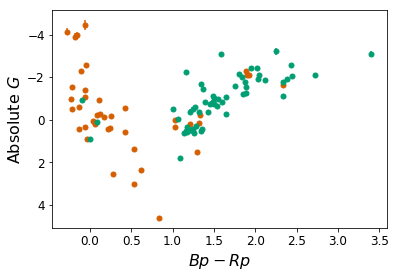

In [53]:
rc('text', usetex=False)
m = np.where(full_cat['TRES?']!='--')[0]
mm = np.where(full_cat['TRES?']=='--')[0]

bp_rp = full_cat['bp_rp']
plt.errorbar(bp_rp[mm],abs_gg[mm],yerr=errorbars[:,mm],fmt='.',color=colours[2],label=r'Smear Campaign (no spectra)',markersize=10)
plt.errorbar(bp_rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear Campaign (with spectra)',markersize=10)
plt.gca().invert_yaxis()
plt.xlabel(r'$Bp-Rp$')
plt.ylabel(r'Absolute $G$')
# plt.legend()

Now we want to use Megan Bedell's Gaia-Kepler crossmatch to situate these in the broader colour-magnitude diagram

In [54]:
kep_data = Table.read('../data/kepler_dr2_4arcsec.fits', format='fits')


In [55]:
kep_data['abs_gmag'] = kep_data['phot_g_mean_mag'] - \
                            5.*(np.log10(kep_data['r_est']) - 1.)
kep_data['abs_gmag'].unit = u.mag

In [56]:
# newcat

In [57]:
# filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax'] > 0.1)
# filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax_over_error'] > 25)

# plt.scatter(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], alpha=0.15, color='k', s=1,label='All Kepler')
# m = np.where(gaia['TRES']!='--')[0]
# plt.errorbar(bp[m]-rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear + spectra',markersize=10)
# plt.errorbar(bp[~m]-rp[~m],abs_gg[~m],yerr=errorbars[:,~m],fmt='.',color=colours[2],label=r'Smear (no spectra)',markersize=10)

# plt.xlabel('Gaia $Bp-Rp$', fontsize=14)
# plt.ylabel(r'Absolute $G$ mag', fontsize=14)
# plt.ylim([13,-6])
# plt.xlim([-0.5,4.1])
# plt.legend()
# plt.title(r'Smear Stars in the Gaia Colour-Magnitude Diagram',y=1.01,fontsize=14)
# # plt.axvline(0.95) # separate giants and dwarfs 
# plt.savefig('../paper/gaia_kepler_hr.png',bbox_inches='tight')

In [58]:
giants = (bp-rp>0.95)
dwarfs = (bp-rp<0.95)
print(giants.sum(),'giants', dwarfs.sum(),'dwarfs',giants.sum()+dwarfs.sum(),'total')
# np.savetxt('giants.txt',cat['Name'][giants])
# np.savetxt('dwarfs.txt',cat['Name'][dwarfs])

66 giants 36 dwarfs 102 total


In [59]:
# # find weird stars in the HR diagram
# rc('text', usetex=False)
# plt.errorbar(bp[dwarfs]-rp[dwarfs],abs_gg[dwarfs],yerr=errorbars[:,dwarfs],fmt='.',color=colours[2],label=r'Dwarfs',markersize=10)
# plt.errorbar(bp[giants]-rp[giants],abs_gg[giants],yerr=errorbars[:,giants],fmt='.',color=colours[1],label=r'Giants',markersize=10)

# weird = ['HD_176582', 'HD_179395']
# for j,w in enumerate(weird):
#     ww = np.where(gaia['Name'] == w)[0]
#     plt.errorbar(bp[ww]-rp[ww],abs_gg[ww],yerr=errorbars[:,ww],fmt='.',color=colours[3+j],label=w,markersize=25)

# plt.gca().invert_yaxis()
# plt.xlabel(r'$Bp-Rp$')
# plt.ylabel(r'Absolute $G$')
# plt.legend()
# plt.savefig('hr_weird.png')

In [60]:
test = Table({'Giants':cat['Name'][giants].data.data.astype('S10')})
test.write('giants.txt',format='ascii',overwrite=True)

test = Table({'dwarfs':cat['Name'][dwarfs].data.data.astype('S10')})
test.write('dwarfs.txt',format='ascii',overwrite=True)

## Now compare to Hypatia

In [61]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('ids')
sim = Simbad.query_objects(cat['Name'])
ids = sim['IDS']

In [62]:
import re
hips = []
for eyedee in ids:
    m = re.search('\|HIP  (.+?)\|',str(eyedee))
    if m:
        found = m.group(1)
#     print found
    hips.append(found)

In [63]:
hinkel = Table.read('../data/hypatia-03082018.csv')

In [64]:
in_hyp = []
for j, hip in enumerate(hips):
    if int(hip) in hinkel['f_hip']:
        print(hip, sim['MAIN_ID'][j])
        in_hyp.append((hip,sim['MAIN_ID'][j]))

96459 b'HD 185351'
92831 b'HD 175740'


In [65]:
in_hyp

[('96459', b'HD 185351'), ('92831', b'HD 175740')]

In [66]:
# import altair as alt
import pandas as pd

In [67]:
pdg = full_cat.to_pandas()
pdg.assign(bprp=pdg.phot_bp_mean_mag - pdg.phot_rp_mean_mag);
pdg.insert(len(pdg.columns), 'bprp', pd.Series(pdg.phot_bp_mean_mag - pdg.phot_rp_mean_mag, index=pdg.index))
pdg.insert(len(pdg.columns), 'name', pd.Series(sim['MAIN_ID'], index=pdg.index))
spec = ['TRES' if sp else 'No  Spectra' for sp in pdg['TRES?']=='TRES']
pdg.insert(len(pdg.columns), 'Spectroscopy', pd.Series(spec, index=pdg.index))
# pdg.insert(len(pdg.columns), 'SpType', pd.Series(newcat['SpType'], index=pdg.index))

# pdkep = kep_data.to_pandas()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: TableReplaceWarning: converted column 'Teff' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: TableReplaceWarning: converted column 'Edge_Dist' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: TableReplaceWarning: converted column 'flame_flags' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


### The *Kepler* dataset is too big for Altair. But not for Bokeh - let's copy from at demo.ipynb from github.com/megbedell/gaia-kepler.fun

In [68]:
from bokeh.plotting import *
from bokeh.io import output_notebook
from bokeh.models import OpenURL, Circle, HoverTool, PanTool, BoxZoomTool, ResetTool, SaveTool, TapTool, WheelZoomTool
from bokeh.util.hex import hexbin
from bokeh.transform import linear_cmap, factor_cmap
from bokeh.palettes import Spectral6
# output_notebook()
reset_output()
output_file("cmd_smear.html")


In [69]:
filter1 = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax_over_error'] > 25)
# filter2 = (kep_data['planet?'] == 'conf') & filter1

filter2 = filter1 

thin = 4

source = ColumnDataSource(
    data=dict(
        kepid=kep_data[filter2]['kepid'].data.data[::thin],
        kepmag=kep_data[filter2]['kepmag'].data.data[::thin],
        bp_rp=kep_data[filter2]['bp_rp'].data.data[::thin],
        abs_gmag=kep_data[filter2]['abs_gmag'].data.data[::thin],
        mass=kep_data[filter2]['mass'].data.data[::thin],
        radius=kep_data[filter2]['radius'].data.data[::thin]
        )
    )

source_smear = ColumnDataSource(
    data=dict(
        name=pdg.name.values,
        abs_gmag=pdg.abs_gg.values,
        bp_rp=pdg.bprp.values,
        spec=pdg.Spectroscopy.values,
        sptype=pdg.SpType.values
        )
    )


In [70]:
# dict(
#         name=pdg.name.values,
#         abs_gmag=pdg.abs_gg.values,
#         bp_rp=pdg.bprp.values,
#         spec=pdg.Spectroscopy.values,
#         sptype=pdg.SpType.values
#         )

In [71]:
# %%time

# xrange = (-0.5,4.1)
# yrange = (13,-6)

# fig = figure(tools="wheel_zoom,pan,reset",x_range=xrange,
#         y_range=yrange,title="Smear Stars in the Gaia Colour-Magnitude Diagram")   
# kep_render = fig.circle('bp_rp','abs_gmag', source=source, size=4, name='KICs',color='black',alpha=0.2)

# smear_render = fig.circle('bp_rp','abs_gmag', source=source_smear, size=10, name='Smear',
#                           color=factor_cmap('spec',palette=Spectral6,factors=pdg.Spectroscopy.values),legend='spec')
# hover = HoverTool(renderers=[smear_render],
#                     tooltips=[
#         ("Name", "@name"),
#         ("Sp. Type","@sptype"),
#         ("Abs. G mag","@abs_gmag"),
#         ("Bp-Rp","@bp_rp")
#                             ]
#     )
# fig.add_tools(hover)
# fig.legend.orientation = "vertical"
# fig.legend.location = "bottom_left"

# fig.xaxis.axis_label = 'Gaia Bp-Rp (mag)'
# fig.yaxis.axis_label = 'Gaia Abs. G Mag'
# fig.xaxis.axis_label_text_font_size = '14pt'
# fig.xaxis.major_label_text_font_size = '12pt'
# fig.yaxis.axis_label_text_font_size = '14pt'   
# fig.yaxis.major_label_text_font_size = '12pt' 
# save(fig)
# # show(fig)


In [72]:
# for j, star in enumerate(pdg.name.values):
#     print j, star, pdg.abs_gg.values[j]

### Let's see if Hipparcos parallaxes differ from Gaia

In [73]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('parallax')
sim = Simbad.query_objects(cat['Name'])
hip_par = sim['PLX_VALUE']


In [74]:
from astroquery.esasky import ESASky
esasky = ESASky()


In [75]:
# hippar = []
# for j, hip in enumerate(hips):
#     print(j, hip)
#     dummy = esasky.query_object_catalogs('HIP'+str(hip),catalogs='HIPPARCOS-2')[0]
#     hippar.append(dummy['plx'].data.data[0])

In [76]:
# parallaxes_hip = np.array(hippar)

In [77]:
# plt.plot(gaia['phot_g_mean_mag'],gaia['parallax']/parallaxes_hip,'.',markersize=12,label='Gaia/Hipparcos')
# plt.axhline(1.,color=colours[1],label='1')
# plt.legend()
# plt.xlabel(r'Gaia $G$ mag')
# plt.ylabel('Parallax Ratio')
# plt.title('Comparison of Gaia and Hipparcos Parallaxes',y=1.01)
# plt.savefig('gaiavship.png')

In [78]:
# plt.plot(gaia['parallax'],parallaxes_hip,'.')
# plt.plot(gaia['parallax'],gaia['parallax'],'-')
# plt.xlabel('Gaia (mas)')
# plt.ylabel('Hipparcos (mas)')
# plt.title('Gaia and Hipparcos Parallaxes')
# plt.savefig('hipparcos_comparison.png')

In [79]:
# plt.hist(gaia['parallax']/parallaxes_hip,bins=20);
# plt.axvline(1,color=colours[2])

### Now let's check everything against the Bright_Kep overall bright kepler catalogue

In [80]:
# import sys
# reload(sys)
# sys.setdefaultencoding('utf8')

brightkep = Table.read('../data/Bright_Kep_new.csv')
# reload(sys)


In [81]:
brightkep.sort('Name')

In [82]:
test = join(cat,brightkep,keys='Name')
test.sort('Name')
test

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,RA,Dec,source_id,Kepler_ID
,,,,,,,,,,,,,,,,,,deg,deg,,
str10,object,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3,float64,float64,int64,int64
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--,294.8603679166666,42.818272500000006,2077959092540451456,7292420
BD+36_3564,K5,--,--,unobserved,4,--,--,--,9.944,8.516,6.134,8.128,141,RG,--,--,--,291.8926695833333,37.117995,2051728490311183744,1575741
BD+39_3577,G5,--,--,unobserved,4,4870,2.513,0.057,8.819,8.062,6.636,8.131,217,RG,--,--,--,283.83340625,40.13883361111111,2103507894472422656,4989821
BD+39_3882,F5,--,--,unobserved,4,6241,4.186,0.02,8.463,8.192,7.36,8.259,0,bad light curve,--,--,--,295.6523554166666,39.99798972222222,2076372669064227200,4850372
BD+42_3150,K0,--,--,unobserved,4,4716,2.329,0.063,9.111,8.257,6.743,8.35,261,not sure,--,--,--,281.25263624999997,42.64371472222222,2116742544137540608,7091342
BD+42_3367,M0,--,--,unobserved,4,--,--,--,9.468,7.756,4.983,7.271,269,RG: low freq,--,--,--,292.6715879166666,43.037706388888886,2125866188548442240,7447756
BD+42_3393,K5,--,--,unobserved,4,--,--,--,9.86,8.149,5.362,7.664,139,RG: low freq,--,--,--,293.95776583333327,42.36609638888889,2077747333469959168,6870455
BD+43_3064,K5,--,--,unobserved,3,--,--,--,10.18,8.692,6.205,8.284,0,RG,--,--,--,281.3657666666666,43.9953375,2117284053614333312,8075287


In [83]:
cat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,RA,Dec,source_id
,,,,,,,,,,,,,,,,,,deg,deg,
str10,object,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3,float64,float64,int64
HD_185351,G8.5IIIbFe-0.5,0.16,1.156,LC:Q1-3 SC:Q16 under,4,--,--,--,6.091,5.176,3.654,5.034,59,RG: Retired A star,Hjorringgaard,--,Yes,294.1582345833333,44.69493333333333,2078403295235690112
HD_186155,F5II-III,0.3,0.57,LC:Q1 under,4,--,--,--,5.44,5.065,4.419,5.055,66,three sharp peaks,--,--,--,295.2091004166667,45.52494083333333,2079990268465009024
HD_175740,G8III,-0.1,1.035,unobserved,4,--,--,--,6.486,5.462,4.08,5.212,0,RG: suppressed l=1,"Tim W, Guy, Cleo",Yes,Yes,283.71740624999995,41.60272027777778,2104485016711846656
HD_184875,A2V,--,0.349,unobserved,4,--,--,--,5.399,5.337,5.128,5.403,0,Classical Pulsator,--,--,--,293.67192416666666,42.41251083333333,2077737571001053312
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--,294.8603679166666,42.818272500000006,2077959092540451456
HD_189178,B5V,--,0.236,unobserved,4,--,--,--,5.356,5.448,5.595,5.552,0,Classical Pulsator,--,--,--,299.30778166666664,40.367825277777776,2073537612700605696
HD_187372,M1III,--,2.693,unobserved,4,--,--,--,7.805,6.141,2.979,5.672,110,RG: low freq,--,--,--,296.86178874999996,47.90757305555555,2086614688589352320
HD_182694,G7IIIa,-0.01,0.771,LC:Q2 under,4,--,--,--,6.76,5.86,4.437,5.722,137,RG,Tim W,Yes,--,290.9854195833333,43.38816722222222,2126062687590513408


In [84]:
pdcat, pdbr = cat.to_pandas(), brightkep.to_pandas()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: TableReplaceWarning: converted column 'Teff' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: TableReplaceWarning: converted column 'Edge_Dist' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [85]:
# pdcat.join(pdbr,on='Name')

### find missing files

In [86]:
import glob
filenames = (glob.glob("../data/lcs/*.csv"))


In [87]:
test = glob.glob("../data/lcs/V543_Lyr_smear_combined.csv")
print(test)

['../data/lcs/V543_Lyr_smear_combined.csv']


In [88]:
for name in cat['Name']:
    test = glob.glob("../data/lcs/%s_smear_combined.csv" % name)
#     print(name, test)

In [89]:
# brightkep['Kepler_ID'].pprint(max_lines=230)

In [90]:
names_in = []
for name in cat['Name']:
    if name not in brightkep['Name']:
        print(name)
        names_in.append(name)
        
print(len(names_in))

0


In [91]:
# brightkep['Name'].pprint(max_lines=230)

###  Load stellar variability classes

In [92]:
var = Table.read('../data/variability.csv')

In [93]:
for name in cat['Name']:
    if name not in var['Name']:
        print(name)

In [94]:
newcat[newcat['Name']=='BD+42_3150']

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,RA,Dec,source_id,Kepler_ID,Class,r_est,r_lo,r_hi,input_position,distance,designation,ra,dec,l,b,ecl_lon,ecl_lat,parallax,pmra,pmdec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,a_g_percentile_lower,a_g_percentile_upper,a_g_val,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_gof_al,astrometric_matched_observations,astrometric_n_bad_obs_al,astrometric_n_good_obs_al,astrometric_n_obs_ac,astrometric_n_obs_al,astrometric_params_solved,astrometric_primary_flag,astrometric_pseudo_colour,astrometric_pseudo_colour_error,astrometric_sigma5d_max,astrometric_weight_al,bp_g,bp_rp,dec_parallax_corr,dec_pmdec_corr,dec_pmra_corr,duplicated_source,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,e_bp_min_rp_val,flame_flags,frame_rotator_object_type,g_rp,lum_percentile_lower,lum_percentile_upper,lum_val,matched_observations,mean_varpi_factor_al,parallax_over_error,parallax_pmdec_corr,parallax_pmra_corr,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_n_obs,phot_bp_rp_excess_factor,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_n_obs,phot_proc_mode,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_n_obs,phot_variable_flag,pmra_pmdec_corr,priam_flags,ra_dec_corr,radial_velocity,radial_velocity_error,radius_percentile_lower,radius_percentile_upper,radius_val,random_index,ra_parallax_corr,ra_pmdec_corr,ra_pmra_corr,ref_epoch,rv_nb_transits,rv_template_fe_h,rv_template_logg,rv_template_teff,solution_id,teff_percentile_lower,teff_percentile_upper,teff_val,visibility_periods_used,other_ids,abs_gg
,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str10,object,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str4,float64,float64,int64,int64,str16,float64,float64,float64,str37,float64,str28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int64,str13,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,str28,float64
BD+42_3150,K0,--,--,unobserved,4,4716,2.329,0.063,9.111,8.257,6.743,8.35,261,not sure,--,--,TRES,281.25263624999997,42.64371472222222,2116742544137540608,7091342,?,545.954282342101,516.819773786676,578.502581535217,"281.25263624999997,42.64371472222222",8.422397243124703e-05,Gaia DR2 2116742544137540608,281.25257984212334,42.6436414279837,71.84130240050959,19.102430329936123,290.0903001407802,65.30002991136283,1.810260879101584,-9.667233324697618,-17.085871041024053,8.31532,8.867191,7.661614,0.0833965852206171,0.10336306252142802,0.10063208011223501,0.18946577372381954,0.1940092928840191,0.0225,1.8848,0.165,5994.6147,0.5149878123912578,94.90074661272668,63.239307,28,4,240,244,244,31,true,1.5165633481068224,0.02642615826869086,0.11096369,3.1026225,0.5518713,1.205577,0.17403364,-0.33679068,-0.18953183,false,0.026,0.9351,0.1157,200111,0,0.6537061,114.53185,130.9376,122.73473,33,0.13006999,17.988905,-0.18029507,-0.16254573,3923546.092826491,6396.341727823126,613.4047,29,1.2188874,8896477.985866254,3094.941002539606,2874.5227,257,0,6920259.0783988,7506.75476036433,921.871,29,NOT_AVAILABLE,0.124484755,100001,0.063017644,-26.9621630433

## Apogee

In [95]:
fname_apogee = '../data/Pope_APOGEEDR14.fits'
apogee = Table.read(fname_apogee)

In [96]:
for j, name in enumerate(apogee['Name']):
    apogee['Name'][j] = name.replace(' ','')
apogee['Object']=apogee['Name']


In [97]:
apogee_seismic = join(apogee,astero_logg,keys='Object')
apogee_seismic['Object']

BD+42_3150
BD+48_2904
HD_175884
HD_180312
HD_180475
HD_181069
HD_182354
HD_182531
HD_226754


In [98]:
apogee_var = join(apogee,var,keys='Name')

In [99]:
apogee_var['Name','Class']

Name,Class
str10,str16
BD+42_3150,?
BD+42_3367,LPV
BD+43_3068,-
BD+48_2904,RG
HD_175466,LPV
HD_175841,GD/DS Hybrid
HD_175884,RG
HD_178090,LPV
HD_179395,a2cvn


### Make a Venn diagram


In [100]:
from matplotlib_venn import venn2, venn3, venn3_circles


ModuleNotFoundError: No module named 'matplotlib_venn'

In [ ]:
seismic_names = set(seismic['Star_ID'])
# seismic_names.remove('HD_189636')
# seismic_names.add('HD_189636A') # typo star make A
spec_names = set(spc_data['Object'][spc_data['Object']!='HD_176466']) # typo star remove
all_names = set(newcat['Name'])
# giants_names = set(cat['Name'][giants].data.data.astype('S10'))
# dwarf_names = set(cat['Name'][dwarfs].data.data.astype('S10'))

In [ ]:
def label_by_id(label, ID):
    num = v.get_label_by_id(ID).get_text() 
    v.get_label_by_id(ID).set_text(label+"\n"+num)


labels = ('Asteroseismology','Spectroscopy','All Stars')


In [ ]:
v = venn3([seismic_names,spec_names,all_names],set_labels=labels,alpha=0.2)
lbl = v.get_label_by_id('001')
x, y = lbl.get_position()
lbl.set_position((x, y-0.1))  # Or whatever
lbl = v.get_label_by_id('111')
x, y = lbl.get_position()
lbl.set_position((x-0.3, y))  # Or whatever


venn3_circles([seismic_names,spec_names,all_names],linewidth=0.5);
plt.savefig('../paper/venn.png',bbox_inches='tight')

In [ ]:
for name in spec_names:
    if name not in all_names:
        print('Spectroscopy:',name,'not in main catalogue')

for name in seismic_names:
    if name not in all_names:
        print('Asteroseismology:',name,'not in main catalogue')
        
for name in seismic_names:
    if name not in spec_names:
        print('Asteroseismic data available for',name,'but not spectroscopy')
        
for name in diff['Object']:
    if name not in seismic_names:
#         print 'Abundances data available for',name,'but not asteroseismology'
        print(name)


In [ ]:
seismic[seismic['Star_ID']=='HD_189636']

In [ ]:
spc_data['SNRe'].mean()